# A first distributed simulation

Until now, we've only been working with single grid point simulations. This is fine for learning and playing around with different configurations of the model since the runs takes less time. A more typical use case of COSIPY is to run a distributed simulation over the entire surface of the glacier, which gives us a much more detailed view of the glacier.

In [1]:
# Have to change the cwd for the ipython session, otherwise COSIPY
# will look for things in the wrong places.
import os
import sys
# This is not really a good method, if cell is re run we end up in the
# wrong directory.
os.chdir('./../')
sys.path.append(os.getcwd())

In [2]:
from cosipy.utils import edu_utils
# cfg gives us the NAMELIST
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

In [3]:
# Have to tell matplotlib to plot inline
%matplotlib inline

Setting up a distributed simulation is fairly easy. All we need is 2D input data (3D with time). This data could either be in the form of gcm/reanalysis output or interpolated from station data. For the tutorials we provide a distributed input file `Zhadang_ERA5_2009_dst.nc` for Zhadang. We can take a look at it

In [5]:
# This is where the data is located.
input_path = './data/input/'
with xr.open_dataset(input_path+'Zhadang/Zhadang_ERA5_2009_dst.nc') as ds:
    ds = ds.isel(time=slice(0, -1)).load()
ds

<xarray.Dataset>
Dimensions:   (lat: 7, lon: 13, time: 8759)
Coordinates:
  * lon       (lon) float64 90.62 90.62 90.63 90.63 ... 90.65 90.65 90.65 90.66
  * lat       (lat) float64 30.46 30.46 30.47 30.47 30.47 30.48 30.48
  * time      (time) datetime64[ns] 2009-01-01 ... 2009-12-31T22:00:00
Data variables:
    HGT       (lat, lon) float32 nan nan nan ... 5.79e+03 5.826e+03 5.841e+03
    ASPECT    (lat, lon) float32 nan nan nan nan ... 36.99 150.4 159.7 -164.0
    SLOPE     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    MASK      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    T2        (time, lat, lon) float64 nan nan nan nan ... 250.7 250.5 250.4
    RH2       (time, lat, lon) float64 nan nan nan nan ... 61.44 61.44 61.44
    U2        (time, lat, lon) float64 0.9077 0.9077 0.9077 ... 3.066 3.066
    G         (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PRES      (time, lat, lon) float64 nan nan nan nan ... 491.6 489.2 488.2
    RRR       (time, lat, lon) float64 nan nan nan ... 0.007629 0.007629
    SNOWFALL  (time, lat, lon) float64 nan nan nan ... 2.973e-05 2.973e-05
    N         (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 0.9603 0.9603 0.9603

The input data contains 91 gridpoints. However, only 17 of these are actually within the glacier boundaries and are used for the run. This input data also covers the whole of 2009, so lets also set up the run for a summer month.

<div class="alert alert-warning">
    <details>
        <Summary> <b>Where is the information about the number gridpoints within the glacier?</b> <i>Click me for a hint</i></Summary>
        The points within the glacier are selected based on the MASK variable. You can plot it or "show" the data by pressing the storage symbol in the output above. It also possible to count it with the method .count(). Try it below!
    </details>
</div>

In [15]:
# Empty cell for the reader


## Running a distributed simulation

Now that we've confirmed that the data is of the right dimension, we can initialize the datasets needed to run the simulation. First we have to add the new input file in the `opt_dict`

In [7]:
# The print_options returns a pandas dataframe so we can index it.
edu_utils.print_options().loc['input_netcdf']

value    Zhadang/Zhadang_ERA5_2009.nc
Name: input_netcdf, dtype: object

In [8]:
# opt_dict
opt_dict = dict()
# We change the input_netcdf
opt_dict['input_netcdf'] = 'Zhadang/Zhadang_ERA5_2009_dst.nc'


And lets change the start and end dates

In [19]:
edu_utils.print_options().loc['time_start']

value    2009-01-01T06:00
Name: time_start, dtype: object

In [20]:
opt_dict['time_start'] = '2009-07-01T00:00'
opt_dict['time_end'] = '2009-07-31T00:00'

With this done we can initialize the datasets needed for running the model

In [21]:
IO, DATA, RESULTS = edu_utils.create_IO(opt_dict)


 Maximum available time interval from 2009-01-01T00:00 until 2009-12-31T23:00. Time steps: 8760 


--------------------------------------------------------------
	 Integration from 2009-07-01T00:00 to 2009-07-31T00:00
--------------------------------------------------------------

--------------------------------------------------------------
Checking input data .... 

Temperature data (T2) ... ok 
Relative humidity data (RH2) ... ok 
Shortwave data (G) ... ok 
Wind velocity data (U2) ... ok 
Precipitation data (RRR) ... ok 
Cloud cover data (N) ... ok 
Pressure data (PRES) ... ok 
Snowfall data (SNOWFALL) ... ok 

 Glacier gridpoints: 17 




Output dataset ... ok


The output above confirms that we have 17 glacier gridpoints in our input data.

## Running the model
We are now ready to run the model. This is just as simple as in the one dimensional case. In the background the results of each gridpoint is calculated individually, we're basically stacking multiple point simulations next to each other. The `edu_utils.run_model` distributes the work so that gridpoints are executed in parallel. Note however that this still might take some time.

In [22]:
edu_utils.run_model(DATA, IO, RESULTS, opt_dict)

Model is running, check progress here: Progress is currently disabled
Finished!


As before we can take a quick look at the results. First however, we have to reduce the dimensions of the data. A simple way is to select a single time step

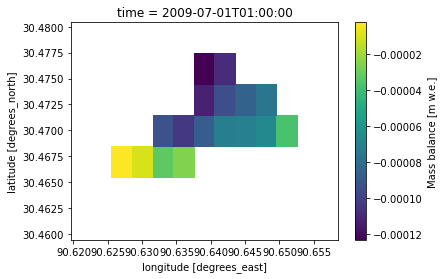

In [23]:
RESULTS.isel(time=1).MB.plot();

Alternatively we can also reduce one of the dimensions by taking the mean of it, creating a so called Hovmöller diagram

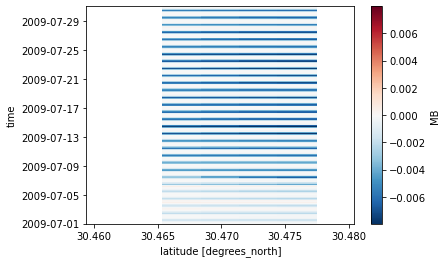

In [24]:
RESULTS.MB.mean(dim='lon').plot();

## Next steps
[Back to overview](welcome.ipynb)
